<a href="https://colab.research.google.com/github/chunt4/cv-piano/blob/main/cvpiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


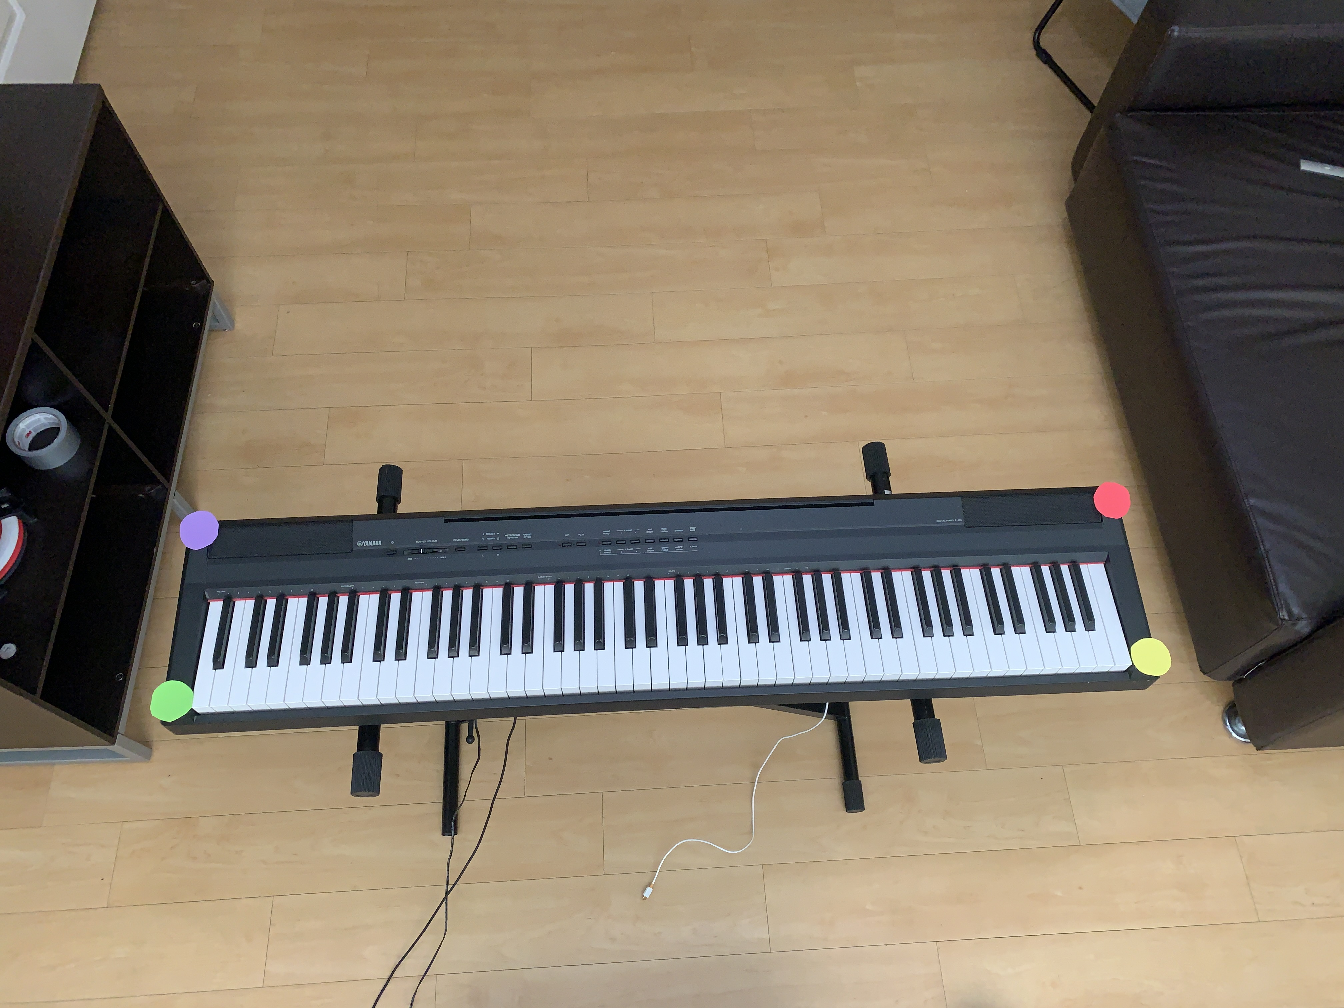

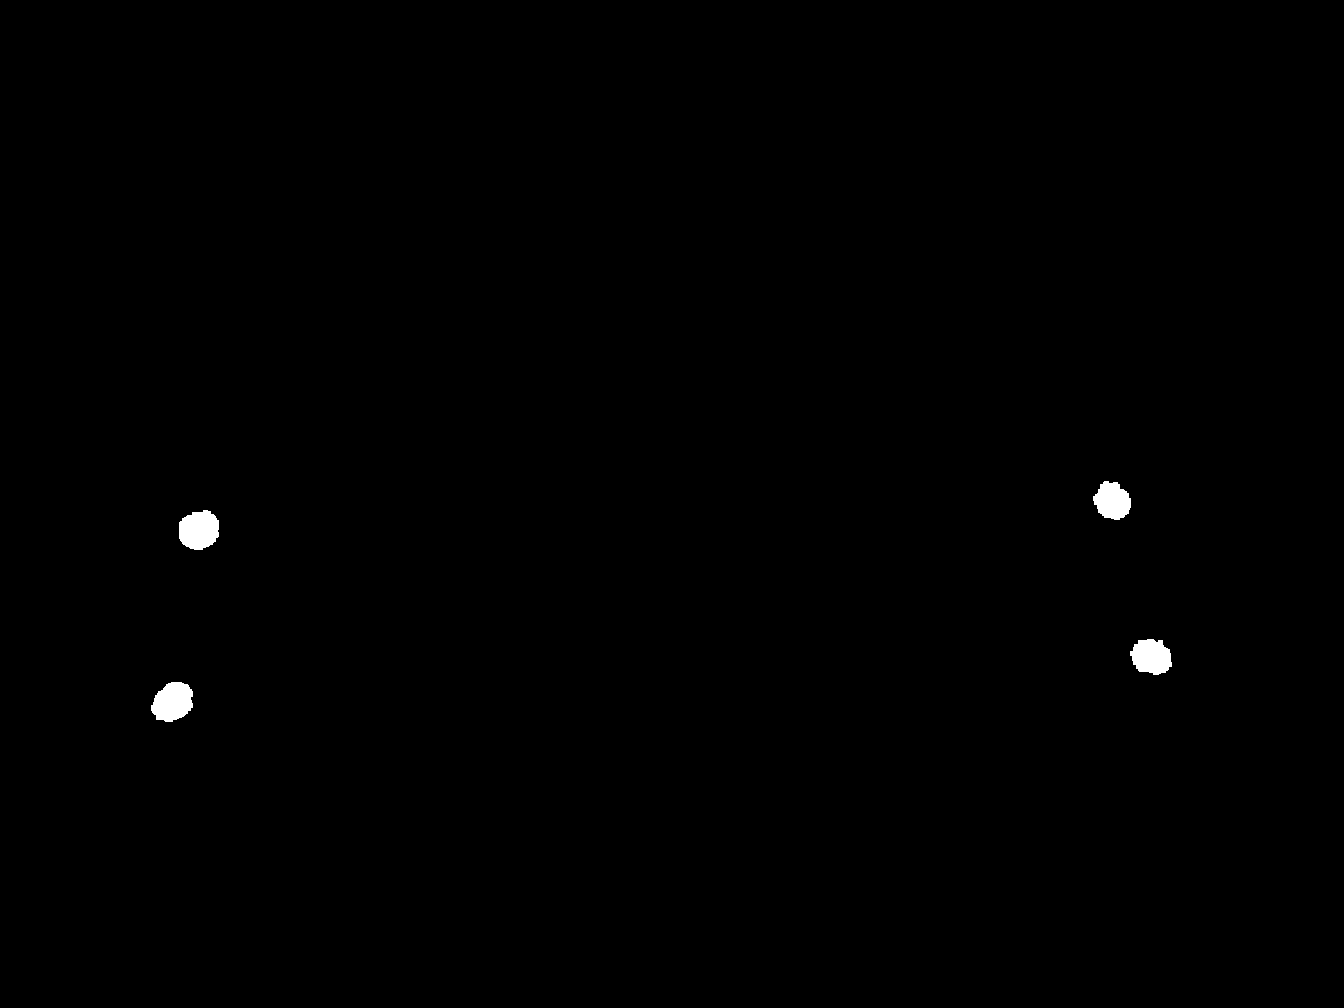

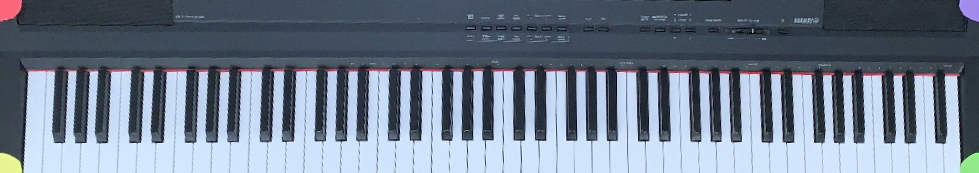

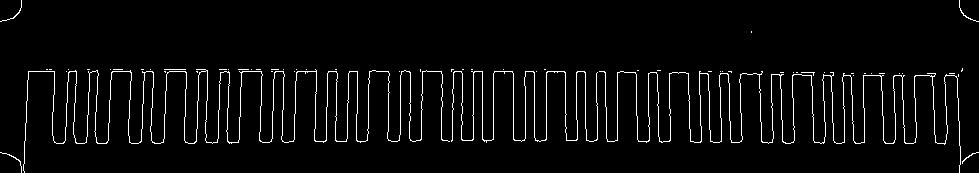

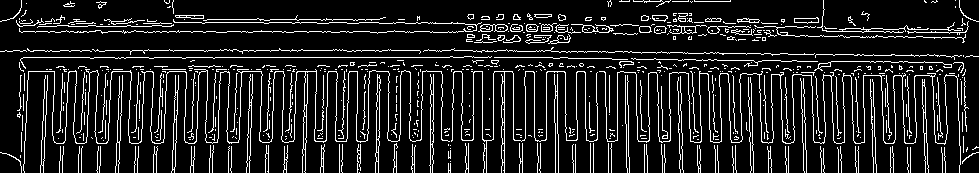

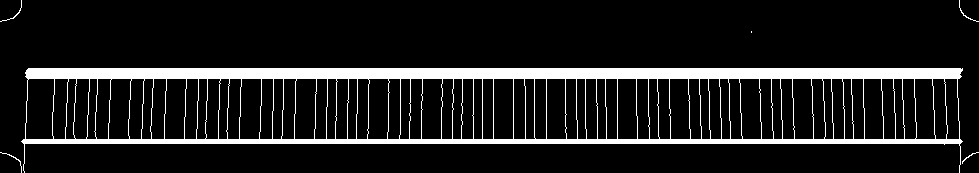

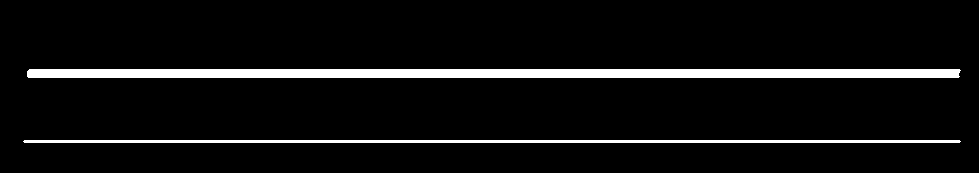




I found 3 objects in total.
[(85.71247478930498, 488.7404578704787), (72.99964243146603, 493.05554231227654), (141.0, 491.5)]
141


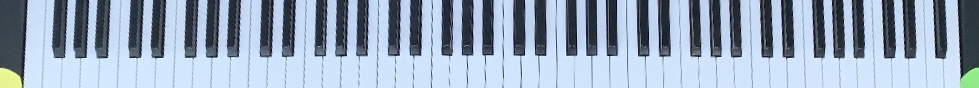

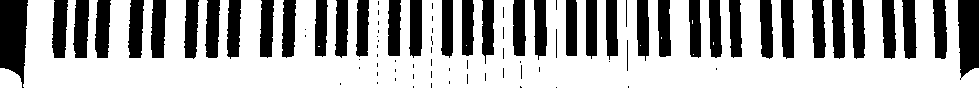

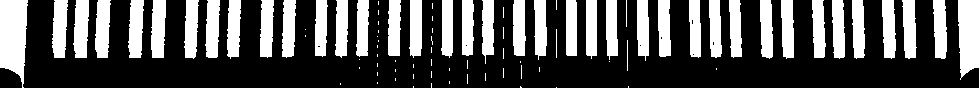

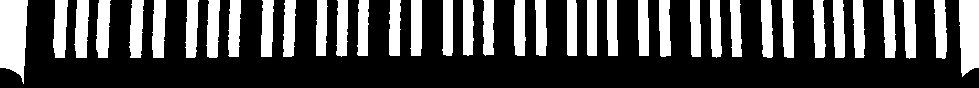




I found 37 objects in total.
[<skimage.measure._regionprops.RegionProperties object at 0x7f556bf87ed0>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf87390>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf87450>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf87050>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf87210>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf92490>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf921d0>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf92190>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf924d0>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf87410>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf920d0>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf92510>, <skimage.measure._regionprops.RegionProperties object at 0x7f556bf92450>, <skim

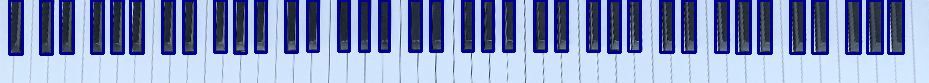




22.0
21.0
33.0
23.0
33.0
21.0
21.0
33.0
22.0
33.0
20.0
21.0
32.0
21.0
32.0
20.0
21.0
31.0
21.0
31.0
20.0
20.0
32.0
21.0
31.0
20.0
20.0
31.0
21.0
31.0
20.0
20.0
31.0
20.0
31.0
The number of white keys found is  49


In [ ]:
# Mounted on chunt4's Google Drive

# Training data path:/content/drive/MyDrive/Computer Vision Semester Project/Data Collection/Training

# Unknown testing path:/content/drive/MyDrive/Computer Vision Semester Project/Data Collection/Unknown Testing

# Validation path:/content/drive/MyDrive/Computer Vision Semester Project/Data Collection/Validation

import cv2
import numpy as np
from skimage import measure
from google.colab import drive
from google.colab.patches import cv2_imshow

# Dan import
#img = cv2.imread('/content/drive/My Drive/Computer Vision Semester Project/IMG_2627.JPG')

# Chris import
img = cv2.imread('/content/drive/My Drive/Computer Vision Semester Project/Data Collection/Training/IMG_2627.JPG')

# Adjust initial image
height, width, channels = img.shape
img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
img = cv2.resize(img, (int(height/3), int(width/3)))
cv2_imshow(img)
print("\n\n")
#cv2.imwrite('img1', img)

### 1. Use HSVSelection Color Extraction and Morphological Operations to Locate Colored Stickers

# Extract RGB values of 4 colored stickers
#Lower left corner
lowerGreen = np.array([135,230,144])
upperGreen = np.array([141,237,149])
objmaskGreen = cv2.inRange(img, lowerGreen, upperGreen)

#Upper left corner
lowerPurple = np.array([234,135,159])
upperPurple = np.array([240,142,166])
objmaskPurple = cv2.inRange(img, lowerPurple, upperPurple)

#Lower right corner
lowerYellow = np.array([142,241,230])
upperYellow = np.array([147,245,234])
objmaskYellow = cv2.inRange(img, lowerYellow, upperYellow)

#Upper right corner
lowerRed = np.array([120,100,249])
upperRed = np.array([125,105,253])
objmaskRed = cv2.inRange(img, lowerRed, upperRed)

#Combine masks and morph close and dilate
mask = objmaskPurple + objmaskRed + objmaskGreen + objmaskYellow
kernel = np.ones((5,5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel=kernel)
cv2_imshow(mask)
print("\n\n")

### 2. Extract Coordinates and Determine ROI

# Skimage Measure
labels = measure.label(mask)
properties = measure.regionprops(labels)

# Grab centroids of all corners
centroids = []
for prop in properties:
  centroids.append(prop.centroid)

### 3. Use Image Warping to Straighten Image and Align Image Corners with Centroids

# Adjust centroids array to prepare for warping
centroids = [[centroids[1][1], centroids[1][0]], [centroids[0][1], centroids[0][0]], [centroids[2][1], centroids[2][0]], [centroids[3][1], centroids[3][0]]]

# Use L2 Normalization to determine image width and length
width_AD = np.sqrt(((centroids[0][0] - centroids[3][0]) ** 2) + ((centroids[0][1] - centroids[3][1]) ** 2))
width_BC = np.sqrt(((centroids[1][0] - centroids[2][0]) ** 2) + ((centroids[1][1] - centroids[2][1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))
height_AB = np.sqrt(((centroids[0][0] - centroids[1][0]) ** 2) + ((centroids[0][1] - centroids[1][1]) ** 2))
height_CD = np.sqrt(((centroids[2][0] - centroids[3][0]) ** 2) + ((centroids[2][1] - centroids[3][1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

# print(maxWidth)
# print(maxHeight)

# Specify mappings of source and destination images
input_pts = np.float32(centroids)
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

# Compute transformation matrix
H_mat = cv2.getPerspectiveTransform(input_pts,output_pts)

# Apply perspective transformation to get final warped image
img_warped = cv2.warpPerspective(img, H_mat, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
img = cv2.rotate(img_warped, cv2.cv2.ROTATE_90_CLOCKWISE)

cv2_imshow(img)
print("\n\n")

### 4. Use Edge Detection to Detect Keys
blurred = cv2.GaussianBlur(img, (5, 5), 0)
black_keys = cv2.Canny(image=blurred, threshold1=220, threshold2=250) # Canny Edge Detection
cv2_imshow(black_keys)
print("\n\n")
all_keys = cv2.Canny(image=blurred, threshold1=10, threshold2=25) # Canny Edge Detection
cv2_imshow(all_keys)

print("\n\n")


# Find the edges in the image using canny detector
edges = cv2.Canny(black_keys, 50, 200)
# Detect points that form a line
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 200, minLineLength=10, maxLineGap=250)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(black_keys, (x1, y1), (x2, y2), (255, 0, 0), 3)
# Show result
cv2_imshow(black_keys)
print("\n\n")
black_keys_boundary = cv2.erode(black_keys, np.ones((3, 3), np.uint8))
cv2_imshow(black_keys_boundary)
print("\n\n")


labels = measure.label(black_keys_boundary, 4)
features = measure.regionprops(labels)
print("I found %d objects in total." % (len(features)))

centroids = []
for feat in features:
  centroids.append(feat.centroid)

print(centroids)

print(int(centroids[2][0]))

key_frame = img[int(centroids[0][0]):, :]
cv2_imshow(key_frame)
print("\n\n")

gray_key_frame = cv2.cvtColor(key_frame, cv2.COLOR_BGR2GRAY)


ret1, binary_image = cv2.threshold(gray_key_frame, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

cv2_imshow(binary_image)
print("\n\n")

inverted_binary_image = cv2.bitwise_not(binary_image)

cv2_imshow(inverted_binary_image)
print("\n\n")


eroded_black_keys = cv2.dilate(inverted_binary_image, np.ones((2, 2), np.uint8))
eroded_black_keys = cv2.erode(eroded_black_keys, np.ones((3, 3), np.uint8))

cv2_imshow(eroded_black_keys)
print("\n\n")

key_frame = key_frame[5:, 28:-22]
eroded_black_keys = eroded_black_keys[5:, 28:-22]

labels = measure.label(eroded_black_keys, 4)
features = measure.regionprops(labels)
print("I found %d objects in total." % (len(features)))
img_copy = key_frame

print(features)
features.remove(features[0])

for prop in features:
    if prop.bbox_area > 10:
        cv2.rectangle(img_copy, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (145, 0, 0), 2)

print("I found %d objects in total." % (len(features)))

img_copy = cv2.flip(img_copy, 1)
cv2_imshow(img_copy)
print("\n\n")

# Detect white keys based on centroids of black keys

# measure distance between centers of black keys
distances = []
num_white_keys = 0
prev_centroid = None
for prop in features:
  curr_centroid = (int(prop.centroid[0]), int(prop.centroid[1]))
  cv2.circle(img_copy, (curr_centroid), 2, (0, 255, 0), 1)
  if prev_centroid != None:
    # Calculate distance between current centroid and previous centroid
    dist = np.linalg.norm(curr_centroid[1] - prev_centroid[1])
    print(dist)
    # Add it to distances array
    distances.append(dist)
    if dist > 27:
      white_keys_in_between = 2
    else:
      white_keys_in_between = 1
    num_white_keys += white_keys_in_between
  prev_centroid = curr_centroid
print('The number of white keys calculated is', num_white_keys)

# will need area_convex for convex hull in surrounding area


# Assign keys with musical information
classes = ('A', 'Bb', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#')

# # We are utilizing Keras API to load the pretrained VGG16 model as our feature extractor for training SVM
# model = VGG16(weights='imagenet')

# # *** TASK 2: 
# # Choose the layer of the VGG model used to get your features (= "network embeddings")
# cnn_codes = 'fc2'

# # Loading our model that will output the network enbeddings specified by us above (instead of a classification decision)
# features_model = Model(inputs=model.input, outputs=model.get_layer(cnn_codes).output)

# # And here is the function that will give us VGG-based features for an image "img"
# def extract_vgg_features(img):
#     # prepare the image for VGG
#     img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
#     img = img[np.newaxis, :, :, :]
#     # call feature extraction
#     return features_model.predict(img)



# EOF


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

#@title Webcam Live Stream Code (Just run this :P )
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:

from google.colab.patches import cv2_imshow

## Skin Color detection

video_stream()

min_YCrCb = np.array([0,133,77],np.uint8)
max_YCrCb = np.array([235,173,127],np.uint8)

# initialze bounding box to empty string
label_html = 'Capturing...'

svm_overlay = ''
count = 0 

while True:
    js_reply = video_frame(label_html, svm_overlay)
    if not js_reply:
        break

    # convert JS response to OpenCV image
    frame = js_to_image(js_reply["img"])
    image = frame
    imageYCrCb = cv2.cvtColor(image,cv2.COLOR_BGR2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)

    skinYCrCb = cv2.bitwise_and(image, image, mask = skinRegionYCrCb)

    cv2_imshow(skinYCrCb)




NameError: ignored

In [ ]:
# Mounted on chunt4's Google Drive

# Training data path:/content/drive/MyDrive/Computer Vision Semester Project/Data Collection/Training

# Unknown testing path:/content/drive/MyDrive/Computer Vision Semester Project/Data Collection/Unknown Testing

# Validation path:/content/drive/MyDrive/Computer Vision Semester Project/Data Collection/Validation

import cv2
import numpy as np
from skimage import measure
from google.colab import drive
from google.colab.patches import cv2_imshow

def getBoxes(img):
  # Dan import
  # img = cv2.imread('/content/drive/My Drive/Computer Vision Semester Project/IMG_3258.jpg')

  # Chris import
  # img = cv2.imread('/content/drive/My Drive/Computer Vision Semester Project/Data Collection/Training/IMG_2627.JPG')

  # Adjust initial image
  height, width, channels = img.shape
  img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
  img = cv2.resize(img, (int(height/1), int(width/1)))
  cv2_imshow(img)
  print("\n\n")

  #cv2.imwrite('img1', img)

  ### 1. Use HSVSelection Color Extraction and Morphological Operations to Locate Colored Stickers

  # Extract RGB values of 4 colored stickers
  #Lower left corner
  lowerGreen = np.array([80,190,120])
  upperGreen = np.array([95,210,125])
  objmaskGreen = cv2.inRange(img, lowerGreen, upperGreen)

  #Upper left corner
  lowerPurple = np.array([165,90,135])
  upperPurple = np.array([180,100,150])
  objmaskPurple = cv2.inRange(img, lowerPurple, upperPurple)

  #Lower right corner
  lowerYellow = np.array([105,240,240])
  upperYellow = np.array([125,252,245])
  objmaskYellow = cv2.inRange(img, lowerYellow, upperYellow)

  #Upper right corner
  lowerRed = np.array([110,60,225])
  upperRed = np.array([125,75,240])
  objmaskRed = cv2.inRange(img, lowerRed, upperRed)

  #Combine masks and morph close and dilate
  mask = objmaskPurple + objmaskRed + objmaskGreen + objmaskYellow
  kernel = np.ones((5,5), np.uint8)
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=kernel)
  mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel=kernel)
  cv2_imshow(mask)
  print("\n\n")

  ### 2. Extract Coordinates and Determine ROI

  # Skimage Measure
  labels = measure.label(mask)
  properties = measure.regionprops(labels)

  # Grab centroids of all corners
  centroids = []
  for prop in properties:
    centroids.append(prop.centroid)

  ### 3. Use Image Warping to Straighten Image and Align Image Corners with Centroids

  # Adjust centroids array to prepare for warping
  centroids = [[centroids[1][1], centroids[1][0]], [centroids[0][1], centroids[0][0]], [centroids[2][1], centroids[2][0]], [centroids[3][1], centroids[3][0]]]

  # Use L2 Normalization to determine image width and length
  width_AD = np.sqrt(((centroids[0][0] - centroids[3][0]) ** 2) + ((centroids[0][1] - centroids[3][1]) ** 2))
  width_BC = np.sqrt(((centroids[1][0] - centroids[2][0]) ** 2) + ((centroids[1][1] - centroids[2][1]) ** 2))
  maxWidth = max(int(width_AD), int(width_BC))
  height_AB = np.sqrt(((centroids[0][0] - centroids[1][0]) ** 2) + ((centroids[0][1] - centroids[1][1]) ** 2))
  height_CD = np.sqrt(((centroids[2][0] - centroids[3][0]) ** 2) + ((centroids[2][1] - centroids[3][1]) ** 2))
  maxHeight = max(int(height_AB), int(height_CD))

  # print(maxWidth)
  # print(maxHeight)

  # Specify mappings of source and destination images
  input_pts = np.float32(centroids)
  output_pts = np.float32([[0, 0],
                          [0, maxHeight - 1],
                          [maxWidth - 1, maxHeight - 1],
                          [maxWidth - 1, 0]])

  # Compute transformation matrix
  H_mat = cv2.getPerspectiveTransform(input_pts,output_pts)

  # Apply perspective transformation to get final warped image
  img_warped = cv2.warpPerspective(img, H_mat, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
  img = cv2.flip(cv2.rotate(img_warped, cv2.cv2.ROTATE_90_CLOCKWISE), 1)


  cv2_imshow(img)
  print("\n\n")

  ### 4. Use Edge Detection to Detect Keys
  blurred = cv2.GaussianBlur(img, (5, 5), 0)
  black_keys = cv2.Canny(image=blurred, threshold1=220, threshold2=250) # Canny Edge Detection
  cv2_imshow(black_keys)
  print("\n\n")


  # Find the edges in the image using canny detector
  edges = cv2.Canny(black_keys, 50, 200)
  # Detect points that form a line
  lines = cv2.HoughLinesP(edges, 1, np.pi/180, 200, minLineLength=1, maxLineGap=650)
  # Draw lines on the image
  for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(black_keys, (x1, y1), (x2, y2), (255, 0, 0), 3)
  # Show result
  cv2_imshow(black_keys)
  print("\n\n")
  
  black_keys_boundary = cv2.erode(black_keys, np.ones((3, 3), np.uint8))
  cv2_imshow(black_keys_boundary)
  print("\n\n THIS")


  labels = measure.label(black_keys_boundary, 4)
  features = measure.regionprops(labels)
  print("I found %d objects in total." % (len(features)))

  centroids = []
  for feat in features:
    centroids.append(feat.centroid)

  print(centroids)

  # print(int(centroids[2][0]))

  key_frame = img[int(centroids[0][0]):, :]
  cv2_imshow(key_frame)
  print("\n\n")

  gray_key_frame = cv2.cvtColor(key_frame, cv2.COLOR_BGR2GRAY)


  ret1, binary_image = cv2.threshold(gray_key_frame, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  cv2_imshow(binary_image)
  print("\n\n")

  inverted_binary_image = cv2.bitwise_not(binary_image)

  cv2_imshow(inverted_binary_image)
  print("\n\n")


  eroded_black_keys = cv2.dilate(inverted_binary_image, np.ones((2, 2), np.uint8), iterations = 2)
  eroded_black_keys = cv2.erode(eroded_black_keys, np.ones((3, 3), np.uint8), iterations = 3)

  cv2_imshow(eroded_black_keys)
  print("\n\n")

  key_frame = key_frame[5:, 20:-15]
  eroded_black_keys = eroded_black_keys[5:, 20:-15]

  labels = measure.label(eroded_black_keys, 4)
  features = measure.regionprops(labels)
  print("I found %d objects in total." % (len(features)))
  img_copy = key_frame

  maxA = 0
  for prop in features:
      if prop.bbox_area > maxA:
        maxA = prop.bbox_area
        removeMe = prop
  features.remove(removeMe)
  
  black_bounding = []
  for prop in features:
      if prop.bbox_area > 10:
          cv2.rectangle(img_copy, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (145, 0, 0), 2)
          black_bounding.append([prop.bbox[1], prop.bbox[0], prop.bbox[3], prop.bbox[2]])


  print("I found %d objects in total." % (len(features)))

  cv2_imshow(img_copy)
  print("\n\n")


  # Detect white keys based on centroids of black keys

  # measure distance between centers of black keys
  distances = []
  white_bounding = []
  num_white_keys = 0
  prev_centroid = None
  print(img_copy.shape)
  for prop in features:
    curr_centroid = (int(prop.centroid[0]), int(prop.centroid[1]))
    if prev_centroid != None:
      # Calculate distance between current centroid and previous centroid
      dist = np.linalg.norm(curr_centroid[1] - prev_centroid[1])
      print(dist)
      # Add it to distances array
      distances.append(dist)
      if dist > 25:
        cv2.rectangle(img_copy, (prev_centroid[1]+2, prev_centroid[0]+30), (prev_centroid[1]+10, prev_centroid[0]+55), (0, 0, 145), 2)
        white_bounding.append([prev_centroid[1]+2, prev_centroid[0]+30, prev_centroid[1]+10, prev_centroid[0]+55])
        cv2.rectangle(img_copy, (curr_centroid[1]-12, curr_centroid[0]+30), (curr_centroid[1]-4, curr_centroid[0]+55), (0, 0, 145), 2)
        white_bounding.append([curr_centroid[1]-12, curr_centroid[0]+30, curr_centroid[1]-4, curr_centroid[0]+55])
        white_keys_in_between = 2
      else:
        cv2.rectangle(img_copy, (prev_centroid[1]+4, prev_centroid[0]+30), (prev_centroid[1]+12, prev_centroid[0]+55), (0, 0, 145), 2)
        white_bounding.append([prev_centroid[1]+4, prev_centroid[0]+30, prev_centroid[1]+12, prev_centroid[0]+55])
        white_keys_in_between = 1
      num_white_keys += white_keys_in_between
    prev_centroid = curr_centroid
  print('The number of white keys calculated is', num_white_keys)


  cv2_imshow(img_copy)


  # Assign keys with musical information
  classes = ('A', 'Bb', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#')

  return(black_bounding, white_bounding)

# EOF

In [ ]:
def cropImg(img, original):
  test_img = img
  img = original
  

  # Adjust initial image
  height, width, channels = img.shape
  img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
  img = cv2.resize(img, (int(height/1), int(width/1)))

  height, width, channels = test_img.shape
  test_img = cv2.rotate(test_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
  test_img = cv2.resize(test_img, (int(height/1), int(width/1)))


  ### 1. Use HSVSelection Color Extraction and Morphological Operations to Locate Colored Stickers

  # Extract RGB values of 4 colored stickers
  #Lower left corner
  lowerGreen = np.array([80,190,120])
  upperGreen = np.array([95,210,125])
  objmaskGreen = cv2.inRange(img, lowerGreen, upperGreen)

  #Upper left corner
  lowerPurple = np.array([165,90,135])
  upperPurple = np.array([180,100,150])
  objmaskPurple = cv2.inRange(img, lowerPurple, upperPurple)

  #Lower right corner
  lowerYellow = np.array([105,240,240])
  upperYellow = np.array([125,252,245])
  objmaskYellow = cv2.inRange(img, lowerYellow, upperYellow)

  #Upper right corner
  lowerRed = np.array([110,60,225])
  upperRed = np.array([125,75,240])
  objmaskRed = cv2.inRange(img, lowerRed, upperRed)

  #Combine masks and morph close and dilate
  mask = objmaskPurple + objmaskRed + objmaskGreen + objmaskYellow
  kernel = np.ones((5,5), np.uint8)
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=kernel)
  mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel=kernel)


  ### 2. Extract Coordinates and Determine ROI

  # Skimage Measure
  labels = measure.label(mask)
  properties = measure.regionprops(labels)

  # Grab centroids of all corners
  centroids = []
  for prop in properties:
    centroids.append(prop.centroid)

  ### 3. Use Image Warping to Straighten Image and Align Image Corners with Centroids

  # Adjust centroids array to prepare for warping
  centroids = [[centroids[1][1], centroids[1][0]], [centroids[0][1], centroids[0][0]], [centroids[2][1], centroids[2][0]], [centroids[3][1], centroids[3][0]]]

  # Use L2 Normalization to determine image width and length
  width_AD = np.sqrt(((centroids[0][0] - centroids[3][0]) ** 2) + ((centroids[0][1] - centroids[3][1]) ** 2))
  width_BC = np.sqrt(((centroids[1][0] - centroids[2][0]) ** 2) + ((centroids[1][1] - centroids[2][1]) ** 2))
  maxWidth = max(int(width_AD), int(width_BC))
  height_AB = np.sqrt(((centroids[0][0] - centroids[1][0]) ** 2) + ((centroids[0][1] - centroids[1][1]) ** 2))
  height_CD = np.sqrt(((centroids[2][0] - centroids[3][0]) ** 2) + ((centroids[2][1] - centroids[3][1]) ** 2))
  maxHeight = max(int(height_AB), int(height_CD))


  # Specify mappings of source and destination images
  input_pts = np.float32(centroids)
  output_pts = np.float32([[0, 0],
                          [0, maxHeight - 1],
                          [maxWidth - 1, maxHeight - 1],
                          [maxWidth - 1, 0]])

  # Compute transformation matrix
  H_mat = cv2.getPerspectiveTransform(input_pts,output_pts)

  # Apply perspective transformation to get final warped image
  img_warped = cv2.warpPerspective(img, H_mat, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
  test_img_warped = cv2.warpPerspective(test_img, H_mat, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

  img = cv2.flip(cv2.rotate(img_warped, cv2.cv2.ROTATE_90_CLOCKWISE), 1)
  test_img = cv2.flip(cv2.rotate(test_img_warped, cv2.cv2.ROTATE_90_CLOCKWISE), 1)


  ### 4. Use Edge Detection to Detect Keys
  blurred = cv2.GaussianBlur(img, (5, 5), 0)
  black_keys = cv2.Canny(image=blurred, threshold1=220, threshold2=250) # Canny Edge Detection



  # Find the edges in the image using canny detector
  edges = cv2.Canny(black_keys, 50, 200)
  # Detect points that form a line
  lines = cv2.HoughLinesP(edges, 1, np.pi/180, 200, minLineLength=1, maxLineGap=650)
  # Draw lines on the image
  for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(black_keys, (x1, y1), (x2, y2), (255, 0, 0), 3)
  
  black_keys_boundary = cv2.erode(black_keys, np.ones((3, 3), np.uint8))



  labels = measure.label(black_keys_boundary, 4)
  features = measure.regionprops(labels)

  centroids = []
  for feat in features:
    centroids.append(feat.centroid)


  key_frame = img[int(centroids[0][0]):, :]
  test_key_frame = test_img[int(centroids[0][0]):, :]

  gray_key_frame = cv2.cvtColor(key_frame, cv2.COLOR_BGR2GRAY)


  ret1, binary_image = cv2.threshold(gray_key_frame, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)



  inverted_binary_image = cv2.bitwise_not(binary_image)



  eroded_black_keys = cv2.dilate(inverted_binary_image, np.ones((2, 2), np.uint8), iterations = 2)
  eroded_black_keys = cv2.erode(eroded_black_keys, np.ones((3, 3), np.uint8), iterations = 3)


  key_frame = key_frame[5:, 20:-15]
  test_key_frame = test_key_frame[5:, 20:-15]

  cv2_imshow(test_key_frame)
  return test_key_frame


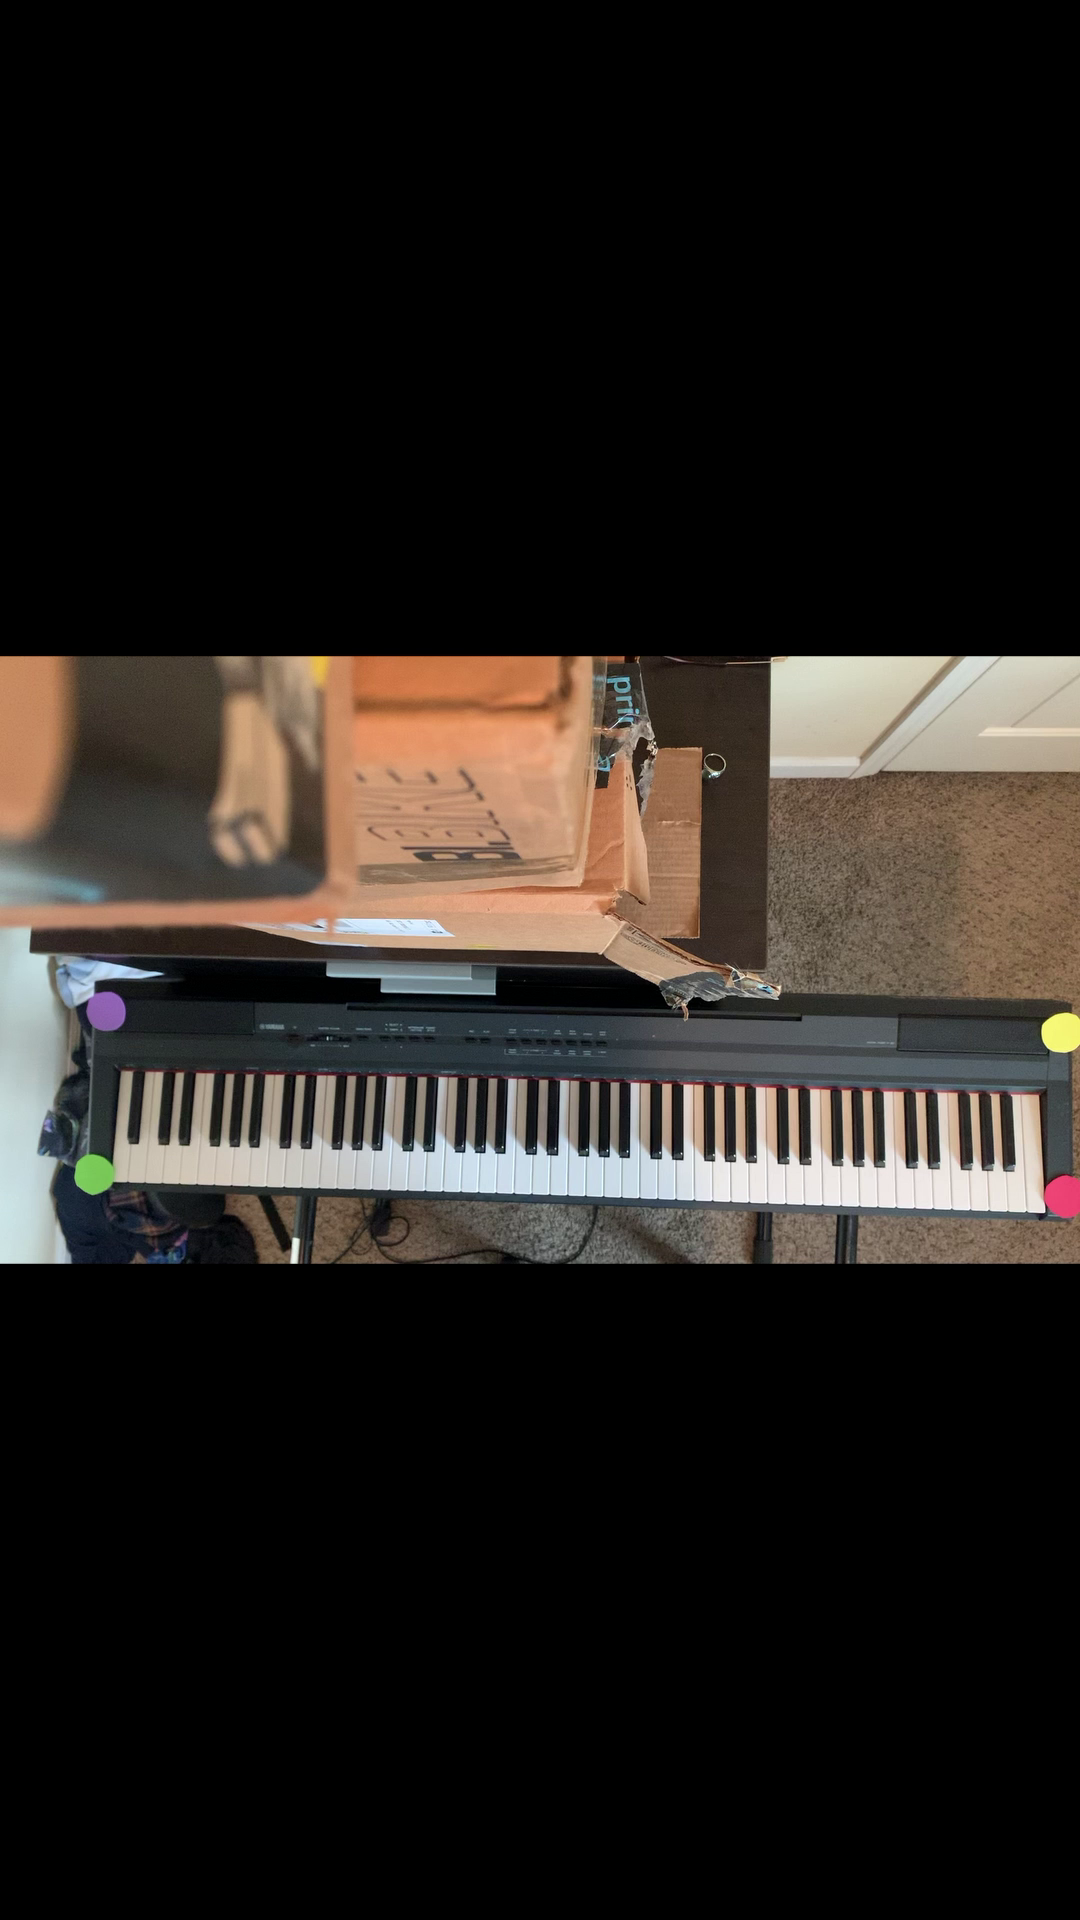

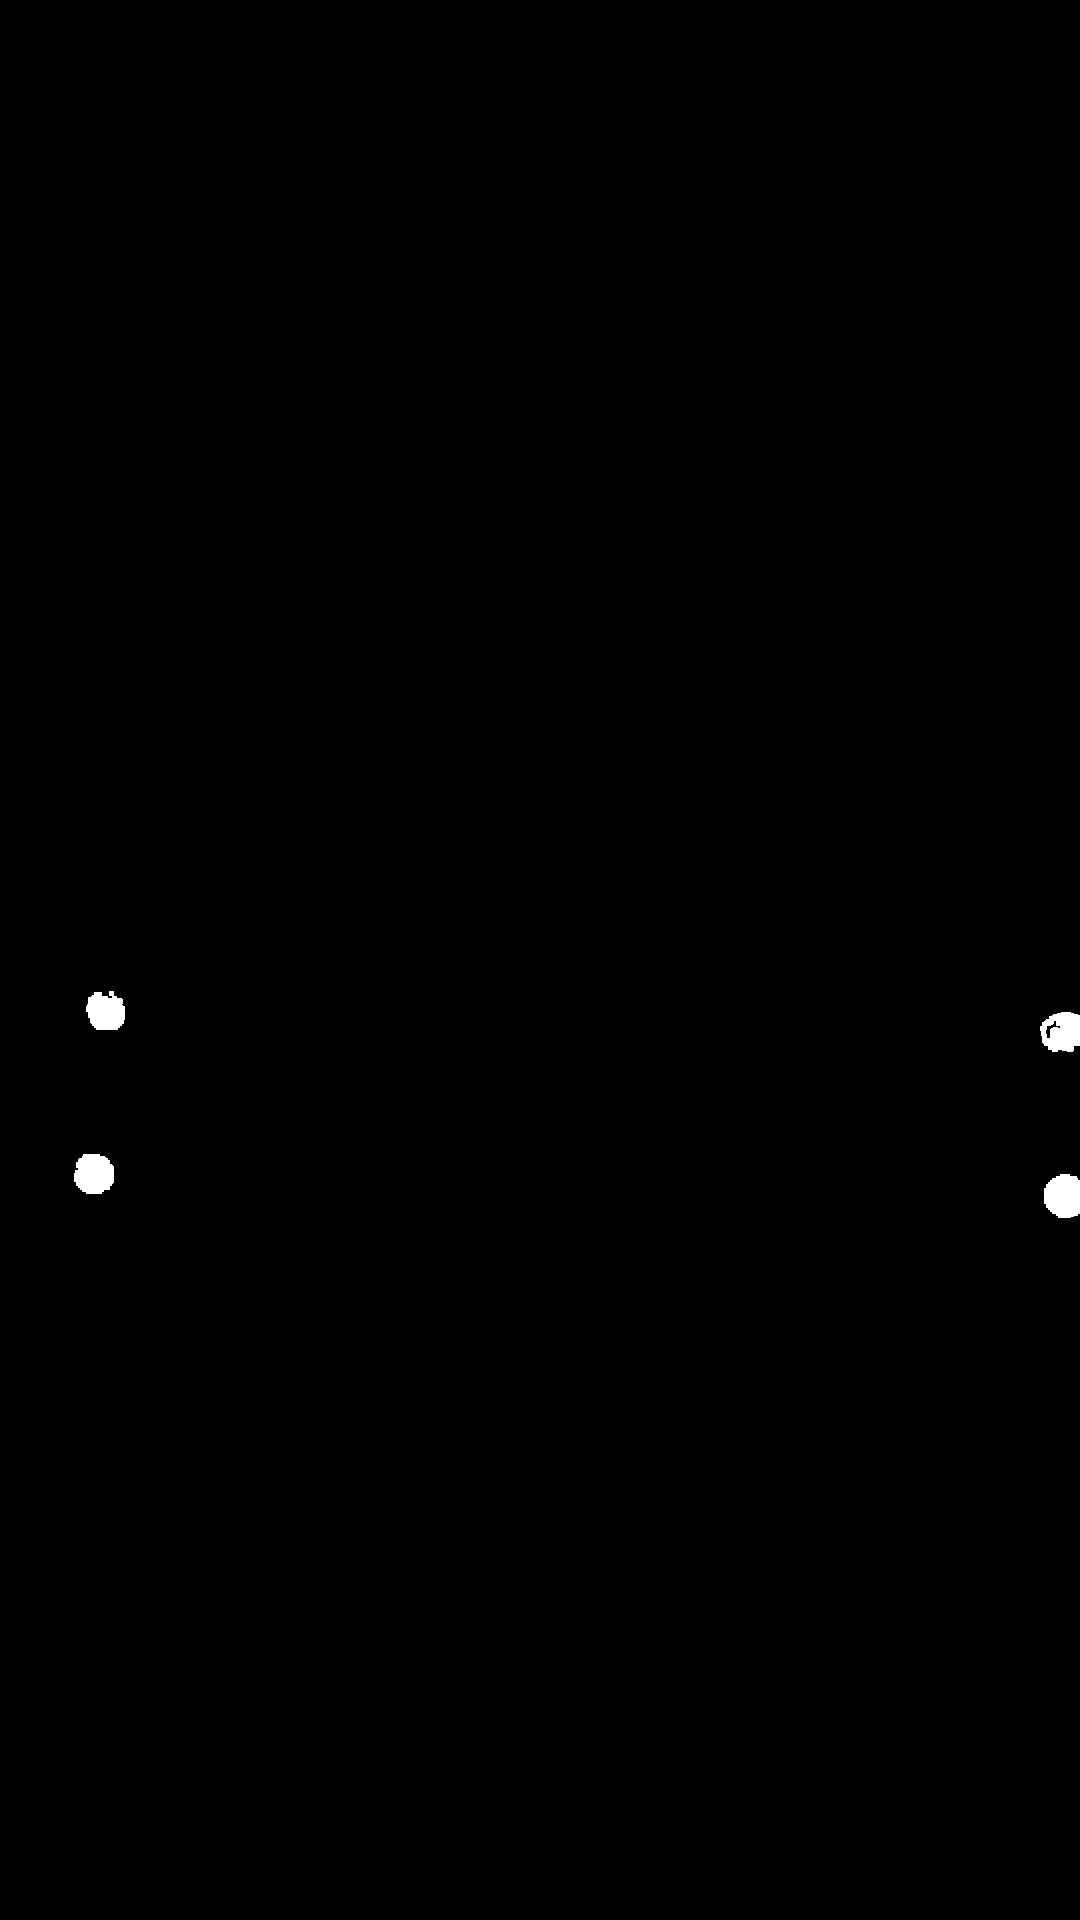

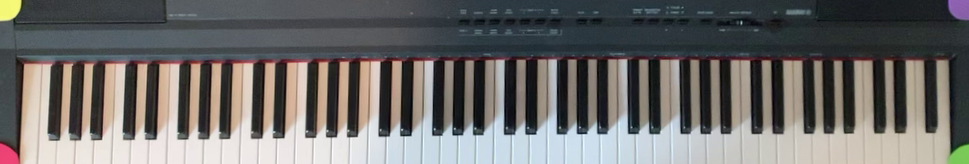

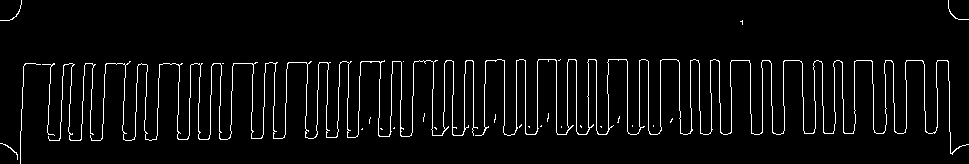

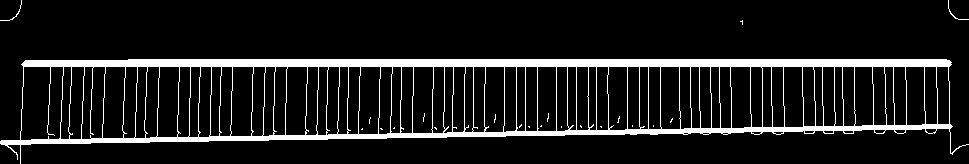

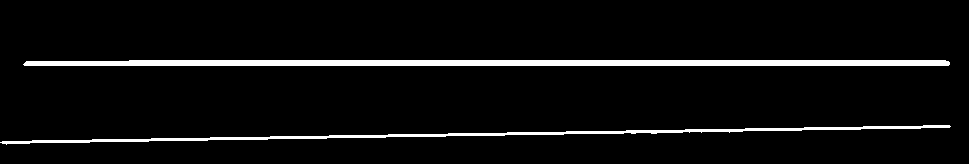



 THIS
I found 3 objects in total.
[(81.19825016761483, 483.78493524425295), (62.55079919162227, 494.0797354400147), (134.00777385159012, 476.06148409893996)]


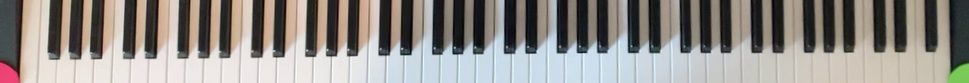

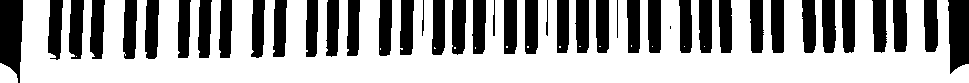

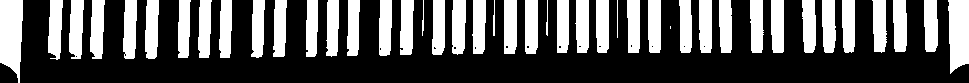

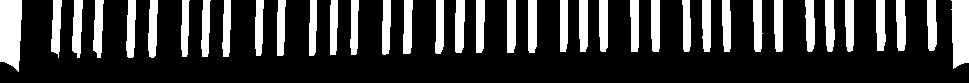




I found 39 objects in total.
I found 38 objects in total.


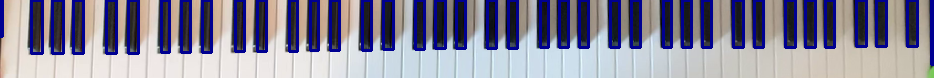




(78, 934, 3)
35.0
21.0
21.0
33.0
22.0
32.0
21.0
21.0
32.0
22.0
32.0
21.0
20.0
32.0
22.0
32.0
20.0
20.0
31.0
21.0
32.0
20.0
20.0
31.0
21.0
31.0
20.0
20.0
31.0
21.0
31.0
20.0
20.0
31.0
20.0
31.0
21.0
The number of white keys calculated is 52


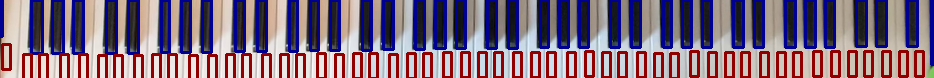

[[0, 0, 2, 36], [31, 0, 42, 53], [52, 0, 63, 53], [73, 0, 83, 53], [106, 0, 116, 53], [128, 0, 138, 53], [161, 0, 169, 52], [181, 0, 190, 52], [202, 0, 211, 52], [235, 0, 244, 51], [257, 0, 266, 51], [289, 0, 297, 51], [310, 0, 318, 50], [330, 0, 339, 50], [362, 0, 371, 50], [383, 0, 393, 49], [415, 0, 424, 49], [435, 0, 445, 48], [456, 0, 465, 48], [487, 0, 496, 48], [508, 0, 517, 48], [540, 0, 548, 47], [559, 0, 568, 47], [579, 0, 588, 47], [610, 0, 619, 47], [631, 0, 640, 47], [663, 0, 671, 47], [682, 0, 691, 47], [702, 0, 711, 47], [733, 0, 743, 47], [754, 0, 763, 47], [785, 0, 795, 47], [805, 0, 815, 47], [825, 0, 834, 47], [856, 0, 866, 46], [876, 0, 886, 46], [907, 0, 917, 46], [931, 0, 934, 64]]
[[2, 44, 10, 69], [23, 54, 31, 79], [39, 54, 47, 79], [60, 54, 68, 79], [79, 54, 87, 79], [98, 55, 106, 80], [114, 55, 122, 80], [134, 55, 142, 80], [152, 54, 160, 79], [168, 54, 176, 79], [189, 55, 197, 80], [208, 55, 216, 80], [226, 54, 234, 79], [242, 54, 250, 79], [262, 54, 270, 79]

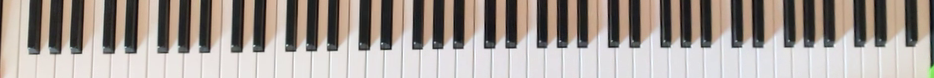

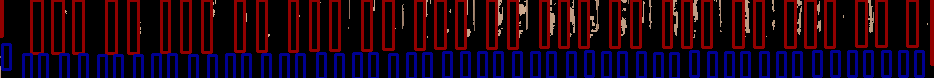

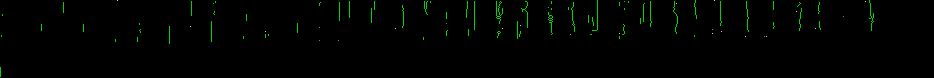

C#
Ab




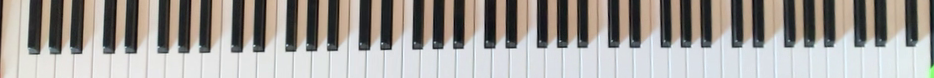

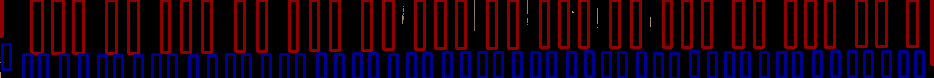

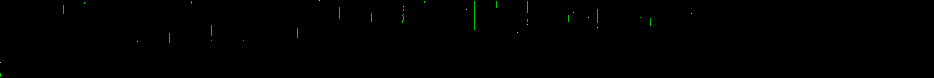

C#
Ab




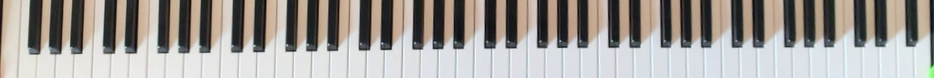

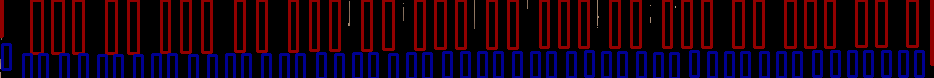

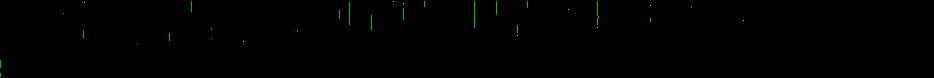

C#
Ab




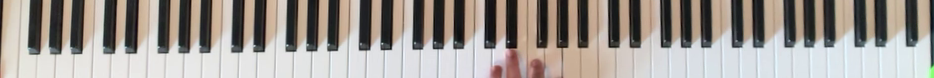

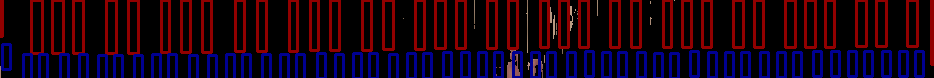

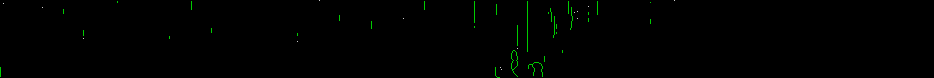

C#
Ab
C
B




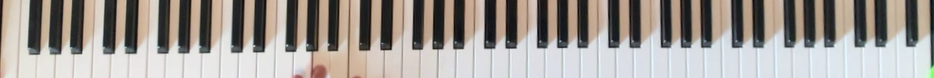

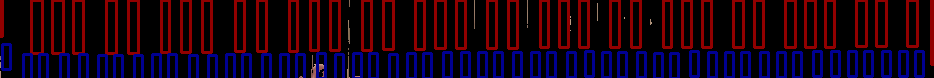

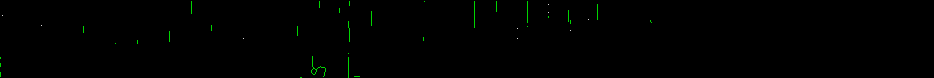

C#
Ab
G




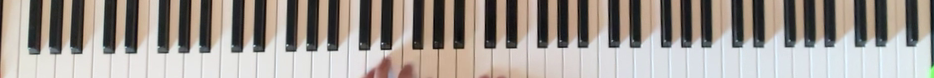

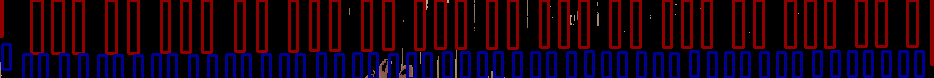

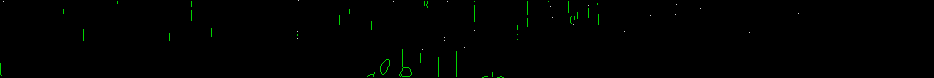

C#
Ab
B




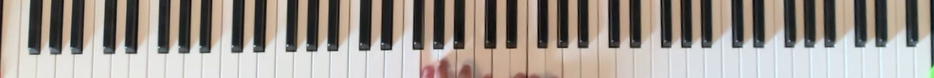

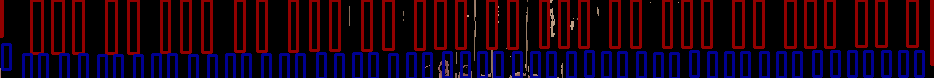

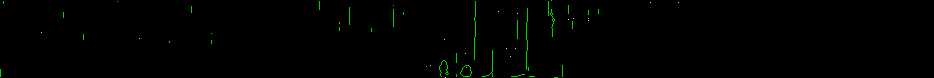

C#
Ab
G




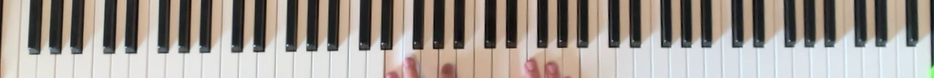

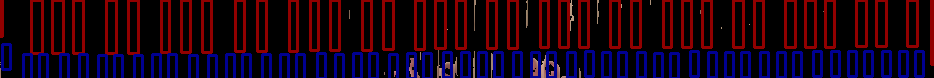

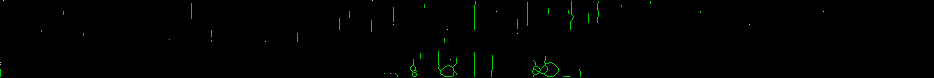

C#
Ab
B
G
B
A




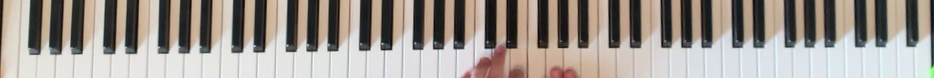

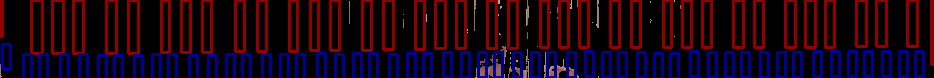

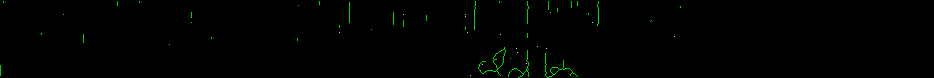

C#
Ab
E
D




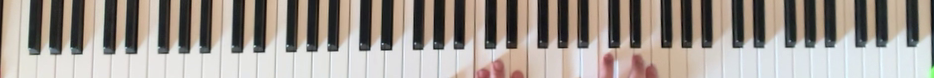

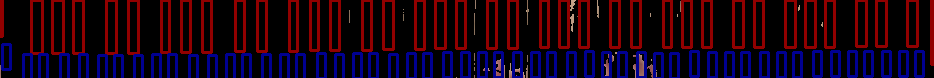

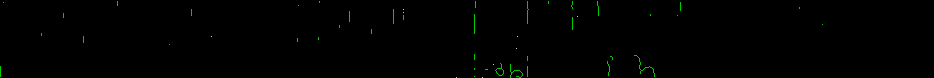

C#
Ab
D
E
C




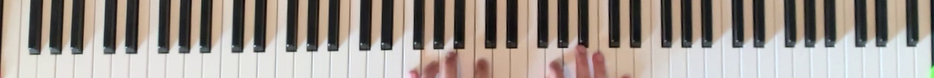

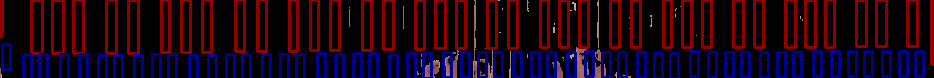

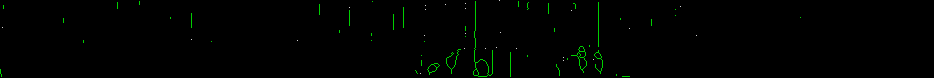

C#
Ab
A
G




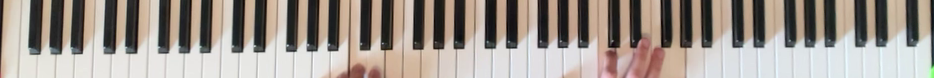

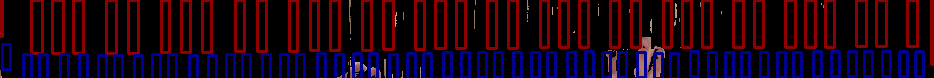

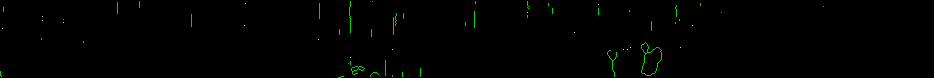

C#
Ab
E
C
B




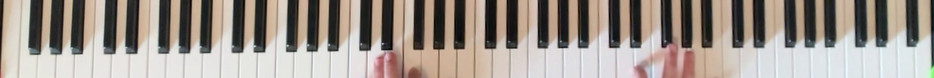

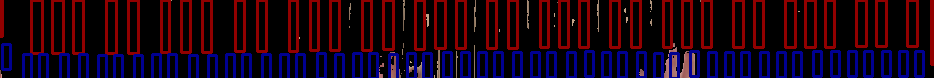

KeyboardInterrupt: ignored

In [ ]:


cap = cv2.VideoCapture('/content/drive/My Drive/Computer Vision Semester Project/dan.mp4')

def getFrame(sec):
  cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
  # Read until video is completed
  # Capture frame-by-frame
  ret, frame = cap.read()
  # if ret:
  #   cv2_imshow(frame)
  return (ret, frame)
  
sec = 0
frameRate = 5 
count=0
success, original = getFrame(sec)

if count == 0:
  black_bounding, white_bounding = getBoxes(original)
  print(black_bounding)
  print(white_bounding)

while success:
    count = count + 1
    savesec = sec
    sec = sec + frameRate
    success, img = getFrame(sec)
    success2, img2 = getFrame(savesec)
    img = cropImg(img, original)
    #img2 = cropImg(img2, original)
    checkNote(img, black_bounding, white_bounding)
    #getHands(img)
    #checkPressed(img2, img)
    print('\n')

cap.release()

In [ ]:
def checkPressed(img_prev, img_new):

  img_prev = cv2.cvtColor(img_prev, cv2.COLOR_BGR2GRAY)
  img_new = cv2.cvtColor(img_new, cv2.COLOR_BGR2GRAY)

  diff = cv2.absdiff(img_new, img_prev)
  thresh = cv2.threshold(diff, 10, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.dilate(thresh, None, iterations=2)
  #(_, cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2_imshow(thresh)
  # if len(cnts) == 0:
  #   return
  # else:
  #   # based on contour area, get the maximum contour which is the hand
  #   segmented = max(cnts, key=cv2.contourArea)

In [ ]:
from skimage.morphology import skeletonize, thin
def checkNote(img, black_bounding, white_bounding):
  lower = np.array([0, 75, 125], dtype = "uint8")
  upper = np.array([20, 120, 225], dtype = "uint8")

  image = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  skinRegion = cv2.inRange(image,lower,upper)

  skin = cv2.bitwise_and(img, img, mask = skinRegion)
  skeleton = skeletonize(skin)

  for b in black_bounding:
    cv2.rectangle(skin, (b[0], b[1]), (b[2], b[3]), (0, 0, 145), 2)

  for b in white_bounding:
    cv2.rectangle(skin, (b[0], b[1]), (b[2], b[3]), (145, 0, 0), 2)
  
  cv2_imshow(skin)
  cv2_imshow(skeleton)

  
  gray = cv2.cvtColor(skin, cv2.COLOR_BGR2GRAY)
  #cv2_imshow(gray)
  for i in range(len(black_bounding)):
    if i == 0:
      pass
    if i == 37:
      pass
    

    # x = np.linspace(black_bounding[i][0], black_bounding[i][2], 1)
    # y = np.linspace(black_bounding[i][1], black_bounding[i][3], 1)

    x = int((black_bounding[i][0] + black_bounding[i][2])/2)
    y = int((black_bounding[i][1] + black_bounding[i][3])/2)

    # for x1 in x:
    #   for y1 in y:
    #     if gray[int(y1)][int(x1)]:
    #       if (i%5 == 1):
    #         print('Bb')
    #       if (i%5 == 2):
    #         print('Ab')
    #       if (i%5 == 3):
    #         print('F#')
    #       if (i%5 == 4):
    #         print('Eb')
    #       if (i%5 == 0):
    #         print('C#')

 
    if gray[y][x]:
      if (i%5 == 1):
        print('Bb')
      if (i%5 == 2):
        print('Ab')
      if (i%5 == 3):
        print('F#')
      if (i%5 == 4):
        print('Eb')
      if (i%5 == 0):
        print('C#')



  for i in range(len(white_bounding)):

    # x = np.linspace(white_bounding[i][0], white_bounding[i][2], 1)
    # y = np.linspace(white_bounding[i][1], white_bounding[i][3], 1)

    x = int((white_bounding[i][0] + white_bounding[i][2])/2)
    y = int((white_bounding[i][1] + white_bounding[i][3])/2)

    # for x1 in x:
    #   for y1 in y:
    #     if gray[int(y1)][int(x1)]:
    #       if (i%7 == 0):
    #         print('C')
    #       if (i%7 == 1):
    #         print('B')
    #       if (i%7 == 2):
    #         print('A')
    #       if (i%7 == 3):
    #         print('G')
    #       if (i%7 == 4):
    #         print('F')
    #       if (i%7 == 5):
    #         print('E')
    #       if (i%7 == 6):
    #         print('D')


    if gray[y][x]:
      if (i%7 == 0):
        print('C')
      if (i%7 == 1):
        print('B')
      if (i%7 == 2):
        print('A')
      if (i%7 == 3):
        print('G')
      if (i%7 == 4):
        print('F')
      if (i%7 == 5):
        print('E')
      if (i%7 == 6):
        print('D')



In [ ]:
!pip install mediapipe
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


def getHands(image):
  # For static images:
  with mp_hands.Hands(
      static_image_mode=True,
      max_num_hands=2,
      min_detection_confidence=0.5) as hands:
      # Read an image, flip it around y-axis for correct handedness output (see
      # above).
      image = cv2.flip(image, 1)
      # Convert the BGR image to RGB before processing.
      results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      # Print handedness and draw hand landmarks on the image.
      print('Handedness:', results.multi_handedness)
      f = 1
      if not results.multi_hand_landmarks:
        f = 0
      if f:
        image_height, image_width, _ = image.shape
        annotated_image = image.copy()
        for hand_landmarks in results.multi_hand_landmarks:
          print('hand_landmarks:', hand_landmarks)
          print(
              f'Index finger tip coordinates: (',
              f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
              f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
          )
          mp_drawing.draw_landmarks(
              annotated_image,
              hand_landmarks,
              mp_hands.HAND_CONNECTIONS,
              mp_drawing_styles.get_default_hand_landmarks_style(),
              mp_drawing_styles.get_default_hand_connections_style())
        cv2_imshow(cv2.flip(annotated_image, 1))
        # Draw hand world landmarks.
        if not results.multi_hand_world_landmarks:
          pass
        for hand_world_landmarks in results.multi_hand_world_landmarks:
          mp_drawing.plot_landmarks(
            hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
